# Imports

In [1]:
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50

import numpy as np
# import tensorflow_hub as hub
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import class_weight
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import glob

print(tf.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")




2.18.0
Using device: cuda


**FUNCTIONS**

In [2]:
import torch.nn.functional as F

def train_and_validate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # lr = optimizer.param_groups[0]['lr']

        print(f"=====================================Epoch: {epoch + 1} / {num_epochs}=====================================")
        train_progress = tqdm(train_loader, total=len(train_loader), leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_progress.set_description(f'[TRAIN] ')
            
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        val_progress = tqdm(val_loader, total=len(val_loader), leave=True)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0) # 1

                probs = F.softmax(outputs, dim=1) # 3
                _, predicted = torch.max(probs, 1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                val_progress.set_description(f'[VALID] ')

        val_loss /= len(val_loader.dataset) # 2
        val_acc = correct / total

        print(f'=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}')

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # scheduler.step()

    
    return history

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def preprocess_image2(image):
    """ 
    Preprocesses an image tensor to make it model ready.
    Args:
        image: Tensor representing the image.
    """
    # If PNG and has 4 channels, remove the alpha channel.
    if image.shape[-1] == 4:
        image = image[..., :-1]
    
    # Ensure the height and width are divisible by 4
    hr_size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, hr_size[0], hr_size[1])
    
    # Cast image to float32
    image = tf.cast(image, tf.float32)
    
    # Add batch dimension
    return tf.expand_dims(image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

  

def pad_to_square(image):
    # Get original dimensions
    old_h, old_w = image.shape[:2]
    
    # Find the larger dimension to make the image square
    max_dim = max(old_h, old_w)
    
    # Calculate padding
    pad_h = (max_dim - old_h) // 2
    pad_w = (max_dim - old_w) // 2
    
    # Ensure padding is non-negative and compatible
    padded_image = tf.image.pad_to_bounding_box(image, pad_h, pad_w, max_dim, max_dim)
    
    # Handle any excess due to rounding differences
    padded_image = tf.image.resize_with_crop_or_pad(padded_image, max_dim, max_dim)
    
    return padded_image

def get_image_index(file_name, image_dir="./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"):
    """
    Retrieves the index of an image file name in the list of loaded images.
    
    Args:
        file_name (str): The file name of the image (e.g., 'image1.jpg').
        image_dir (str): The directory path of the images.

    Returns:
        int: The index of the image in the list of images, or -1 if not found.
    """
    for idx, img_path in enumerate(glob.glob(image_dir)):
        if file_name in img_path:
            return idx
    return -1

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

from tqdm import tqdm

# Training and evaluation loop
def train_model(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

        # Calculate training accuracy
        train_loss = running_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on the validation set
        val_acc, val_loss = evaluate_model(model, val_dataloader, criterion)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    return history  # Return the history dictionary


# Evaluation loop
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc, val_loss / len(dataloader)

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Define the function for predicting and measuring speed
def predict_image(model, image_path, device, class_labels):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet's requirements
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    # Calculate prediction probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    prediction_time = time.time() - start_time

    return predicted_class, prediction_time, probabilities[0]  # Return class, time, and probabilities

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Print raw logits before softmax
    print("Logits:", logits)

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time

def plot_from_history(history, max_epochs):
    # Extract data from the history dictionary
    if isinstance(history['epoch'], range):
        # 'epoch' is a column in the DataFrame
        epochs = list(history['epoch'])[:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]

    elif isinstance(history['epoch'], list):
        # 'epoch' is a list
        epochs = history['epoch'][:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]
    else:
        # 'epoch' is a range object
        history_filtered = history[history['epoch'] <= max_epochs]
        epochs = history_filtered['epoch']
        train_losses = history_filtered['train_loss']
        val_losses = history_filtered['val_loss']
        train_accuracies = history_filtered['train_accuracy']
        val_accuracies = history_filtered['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid

    # Save the plot
    plt.tight_layout()
    plt.show()
def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df

def get_class_labels(dataset_dir):
    # Get all folder names in the directory, which are your class labels
    class_labels = sorted(os.listdir(dataset_dir))  # Assuming each subfolder is a class
    return class_labels

# Dataset Preparation

In [ ]:
train_dir = './DATASET/TRAIN'
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN_UNET - ESRGAN'
test_dir = './DATASET/TEST - mergedval'
enhancedtest_dir = './DATASET/TEST_ESRGAN_UNET - ESRGAN-mergedval'
validation_dir = './DATASET/VALIDATION'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN_UNET - ESRGAN'

seed = 42
np.random.seed(seed)
random.seed(seed)


**PYTORCH**

In [11]:

from sklearn.utils import compute_class_weight

# Hyperparameters
img_height, img_width = 224, 224
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False  # Ensures deterministic behavior


# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    #transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2), shear=5),
#    transforms.ColorJitter(brightness=(0.8, 1.2)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=val_test_transform) # train transform for augmented
val_dataset = datasets.ImageFolder(validation_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Enhanced datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=val_test_transform) # train transform for augmented
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=val_test_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

y_true = [sample[1] for sample in train_dataset.samples]  # Extract the labels (index 1 in each tuple)

# Compute class weights based on the class distribution in y_true
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_true), y=y_true)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")


Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 720
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


<Figure size 600x600 with 0 Axes>

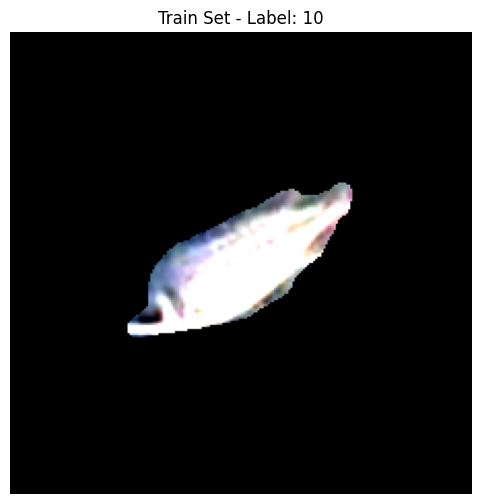

<Figure size 600x600 with 0 Axes>

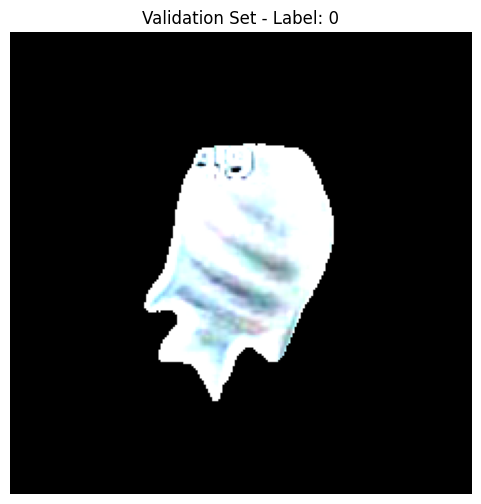

<Figure size 600x600 with 0 Axes>

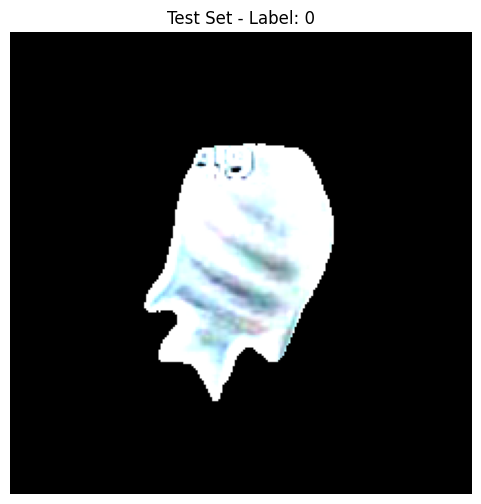

In [5]:
import matplotlib.pyplot as plt

# Function to denormalize and plot images
def imshow(image, ax=None, title=None):
    # Denormalize the image (convert it back to its original range)
    image = image / 2 + 0.5  # Unnormalize (inverse of normalization)
    image = image.numpy().transpose((1, 2, 0))  # Convert tensor to numpy (HWC format)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    ax.axis('off')  # Hide axes
    if title:
        ax.set_title(title)

# Plot random samples from the train, val, and test sets
def plot_random_images(loader, dataset_name="Dataset"):
    # Randomly select a batch from the loader
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Randomly pick an index in the batch
    random_idx = 3

    # Get the image and label
    img = images[random_idx]
    label = labels[random_idx]

    # Display the image
    plt.figure(figsize=(6, 6))
    imshow(img, title=f'{dataset_name} - Label: {label}')

# Plot random images from the datasets
plot_random_images(enhanced_train_loader, "Train Set")
plot_random_images(enhanced_val_loader, "Validation Set")
plot_random_images(enhanced_test_loader, "Test Set")


# PYTORCH (BASELINE)

In [12]:
learning_rate = 0.001
epochs = 30


torch_baseline = resnet50(weights="IMAGENET1K_V1").to(device)

# FREEZE ALL LAYERS
for param in torch_baseline.parameters():
    param.requires_grad = False

class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_baseline_model.fc.parameters(), lr=learning_rate)

for name, layer in torch_baseline_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')



: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [ ]:
# Not Enhanced No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


=> Train Loss=2.4544, Val Loss=1.5498 |  Train Acc=0.4592,  Val Acc=0.7222
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.48it/s]


=> Train Loss=1.6606, Val Loss=1.1435 |  Train Acc=0.7772,  Val Acc=0.8097
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


=> Train Loss=1.2936, Val Loss=0.9673 |  Train Acc=0.8362,  Val Acc=0.8444
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


=> Train Loss=1.0832, Val Loss=0.8244 |  Train Acc=0.8565,  Val Acc=0.8514
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.9116, Val Loss=0.7070 |  Train Acc=0.8749,  Val Acc=0.8708
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.7959, Val Loss=0.6211 |  Train Acc=0.8892,  Val Acc=0.8847
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.94it/s]


=> Train Loss=0.7040, Val Loss=0.5931 |  Train Acc=0.9017,  Val Acc=0.8917
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


=> Train Loss=0.6524, Val Loss=0.5278 |  Train Acc=0.9059,  Val Acc=0.8986
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.5776, Val Loss=0.4924 |  Train Acc=0.9119,  Val Acc=0.9014
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


=> Train Loss=0.5333, Val Loss=0.4622 |  Train Acc=0.9130,  Val Acc=0.9083
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.09it/s]


=> Train Loss=0.4749, Val Loss=0.4345 |  Train Acc=0.9279,  Val Acc=0.9208
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.4706, Val Loss=0.4456 |  Train Acc=0.9214,  Val Acc=0.9014
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.16it/s]


=> Train Loss=0.4239, Val Loss=0.4090 |  Train Acc=0.9202,  Val Acc=0.9069
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.3764, Val Loss=0.3701 |  Train Acc=0.9375,  Val Acc=0.9208
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


=> Train Loss=0.3663, Val Loss=0.3676 |  Train Acc=0.9375,  Val Acc=0.9097
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.23it/s]


=> Train Loss=0.3606, Val Loss=0.3716 |  Train Acc=0.9369,  Val Acc=0.9056
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]


=> Train Loss=0.3428, Val Loss=0.3457 |  Train Acc=0.9345,  Val Acc=0.9236
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.3239, Val Loss=0.3203 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.3062, Val Loss=0.3116 |  Train Acc=0.9369,  Val Acc=0.9319
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.2812, Val Loss=0.3126 |  Train Acc=0.9434,  Val Acc=0.9306
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.2696, Val Loss=0.2967 |  Train Acc=0.9494,  Val Acc=0.9292
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.14it/s]


=> Train Loss=0.2738, Val Loss=0.2997 |  Train Acc=0.9392,  Val Acc=0.9292
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.15it/s]


=> Train Loss=0.2431, Val Loss=0.2789 |  Train Acc=0.9535,  Val Acc=0.9333
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.2484, Val Loss=0.2882 |  Train Acc=0.9422,  Val Acc=0.9347
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.97it/s]


=> Train Loss=0.2429, Val Loss=0.2740 |  Train Acc=0.9506,  Val Acc=0.9292
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


=> Train Loss=0.2345, Val Loss=0.2729 |  Train Acc=0.9482,  Val Acc=0.9347
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


=> Train Loss=0.2274, Val Loss=0.2683 |  Train Acc=0.9547,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.00it/s]


=> Train Loss=0.2115, Val Loss=0.2579 |  Train Acc=0.9535,  Val Acc=0.9361
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.89it/s]


=> Train Loss=0.1991, Val Loss=0.2664 |  Train Acc=0.9577,  Val Acc=0.9361
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.01it/s]

=> Train Loss=0.1911, Val Loss=0.2592 |  Train Acc=0.9565,  Val Acc=0.9361


In [ ]:
# ENHANCED No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


=> Train Loss=2.4885, Val Loss=1.6751 |  Train Acc=0.4753,  Val Acc=0.7014
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=1.7157, Val Loss=1.2211 |  Train Acc=0.7570,  Val Acc=0.8028
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=1.3342, Val Loss=1.0580 |  Train Acc=0.8350,  Val Acc=0.8153
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=1.1161, Val Loss=0.8437 |  Train Acc=0.8553,  Val Acc=0.8639
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.9691, Val Loss=0.7409 |  Train Acc=0.8731,  Val Acc=0.8778
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.8252, Val Loss=0.6651 |  Train Acc=0.8839,  Val Acc=0.8819
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.7573, Val Loss=0.6276 |  Train Acc=0.8827,  Val Acc=0.8833
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=0.6582, Val Loss=0.5760 |  Train Acc=0.8999,  Val Acc=0.8847
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.6011, Val Loss=0.5446 |  Train Acc=0.9065,  Val Acc=0.8986
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=0.5419, Val Loss=0.4884 |  Train Acc=0.9136,  Val Acc=0.9069
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


=> Train Loss=0.5090, Val Loss=0.4532 |  Train Acc=0.9119,  Val Acc=0.9222
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.4756, Val Loss=0.4627 |  Train Acc=0.9172,  Val Acc=0.9125
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.4451, Val Loss=0.4184 |  Train Acc=0.9214,  Val Acc=0.9153
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.3951, Val Loss=0.4100 |  Train Acc=0.9381,  Val Acc=0.9153
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3997, Val Loss=0.3778 |  Train Acc=0.9232,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.75it/s]


=> Train Loss=0.3598, Val Loss=0.3721 |  Train Acc=0.9357,  Val Acc=0.9125
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3346, Val Loss=0.3703 |  Train Acc=0.9404,  Val Acc=0.9194
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


=> Train Loss=0.3365, Val Loss=0.3556 |  Train Acc=0.9351,  Val Acc=0.9250
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.3194, Val Loss=0.3485 |  Train Acc=0.9434,  Val Acc=0.9153
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


=> Train Loss=0.3123, Val Loss=0.3403 |  Train Acc=0.9375,  Val Acc=0.9222
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


=> Train Loss=0.2839, Val Loss=0.3179 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


=> Train Loss=0.2719, Val Loss=0.2943 |  Train Acc=0.9422,  Val Acc=0.9417
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


=> Train Loss=0.2669, Val Loss=0.3001 |  Train Acc=0.9470,  Val Acc=0.9444
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:37<00:00,  1.20it/s]


=> Train Loss=0.2541, Val Loss=0.2828 |  Train Acc=0.9482,  Val Acc=0.9417
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


=> Train Loss=0.2464, Val Loss=0.2782 |  Train Acc=0.9547,  Val Acc=0.9375
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2420, Val Loss=0.2925 |  Train Acc=0.9482,  Val Acc=0.9375
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


=> Train Loss=0.2318, Val Loss=0.2810 |  Train Acc=0.9529,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2110, Val Loss=0.2714 |  Train Acc=0.9595,  Val Acc=0.9444
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


=> Train Loss=0.1910, Val Loss=0.2681 |  Train Acc=0.9571,  Val Acc=0.9347
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]

=> Train Loss=0.2123, Val Loss=0.2591 |  Train Acc=0.9535,  Val Acc=0.9458


In [13]:
# ENHANCED + UNET No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=2.4509, Val Loss=1.6335 |  Train Acc=0.4556,  Val Acc=0.7250
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=1.6661, Val Loss=1.2386 |  Train Acc=0.7635,  Val Acc=0.8347
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=1.3393, Val Loss=0.9578 |  Train Acc=0.7999,  Val Acc=0.8583
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=1.1039, Val Loss=0.8861 |  Train Acc=0.8261,  Val Acc=0.8667
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=0.9282, Val Loss=0.7400 |  Train Acc=0.8600,  Val Acc=0.8861
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.8448, Val Loss=0.6614 |  Train Acc=0.8672,  Val Acc=0.8972
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=0.7461, Val Loss=0.6356 |  Train Acc=0.8809,  Val Acc=0.8931
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.6904, Val Loss=0.5526 |  Train Acc=0.8785,  Val Acc=0.8972
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.6231, Val Loss=0.4983 |  Train Acc=0.8916,  Val Acc=0.9083
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.5961, Val Loss=0.4973 |  Train Acc=0.8809,  Val Acc=0.9056
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.5335, Val Loss=0.4673 |  Train Acc=0.9023,  Val Acc=0.9111
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.5089, Val Loss=0.4210 |  Train Acc=0.8910,  Val Acc=0.9222
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.15it/s]


=> Train Loss=0.4892, Val Loss=0.4169 |  Train Acc=0.9023,  Val Acc=0.9167
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.4412, Val Loss=0.4042 |  Train Acc=0.9107,  Val Acc=0.9167
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


=> Train Loss=0.4275, Val Loss=0.3688 |  Train Acc=0.9113,  Val Acc=0.9292
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


=> Train Loss=0.4065, Val Loss=0.3808 |  Train Acc=0.9107,  Val Acc=0.9250
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.3959, Val Loss=0.3732 |  Train Acc=0.9095,  Val Acc=0.9278
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.3711, Val Loss=0.3581 |  Train Acc=0.9261,  Val Acc=0.9236
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.3601, Val Loss=0.3437 |  Train Acc=0.9214,  Val Acc=0.9250
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.3160, Val Loss=0.3153 |  Train Acc=0.9357,  Val Acc=0.9347
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.3141, Val Loss=0.3249 |  Train Acc=0.9345,  Val Acc=0.9333
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.3423, Val Loss=0.3075 |  Train Acc=0.9267,  Val Acc=0.9333
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.3064, Val Loss=0.3181 |  Train Acc=0.9214,  Val Acc=0.9292
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.2939, Val Loss=0.3075 |  Train Acc=0.9422,  Val Acc=0.9375
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.2946, Val Loss=0.3186 |  Train Acc=0.9315,  Val Acc=0.9208
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.2723, Val Loss=0.2879 |  Train Acc=0.9345,  Val Acc=0.9319
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.2823, Val Loss=0.2821 |  Train Acc=0.9291,  Val Acc=0.9375
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.2649, Val Loss=0.2803 |  Train Acc=0.9410,  Val Acc=0.9278
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


=> Train Loss=0.2580, Val Loss=0.2781 |  Train Acc=0.9333,  Val Acc=0.9417
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]

=> Train Loss=0.2539, Val Loss=0.2852 |  Train Acc=0.9369,  Val Acc=0.9347


# BASELINE RESULTS & VISUALIZATION

**REPORT**


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.83      0.89        30
 Acanthurus Nigrofuscus       0.88      0.80      0.84        64
   Balistapus Undulatus       0.91      0.77      0.83        13
 Canthigaster Valentini       0.88      1.00      0.93        43
 Chaetodon Trifascialis       0.91      0.89      0.90        57
   Hemigymnus Fasciatus       0.97      0.93      0.95        72
  Hemigymnus Melapterus       0.76      1.00      0.87        13
        Lutjanus fulvus       0.98      1.00      0.99        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       1.00      0.94      0.97        54
               Scaridae       0.71      0.88      0.79        17


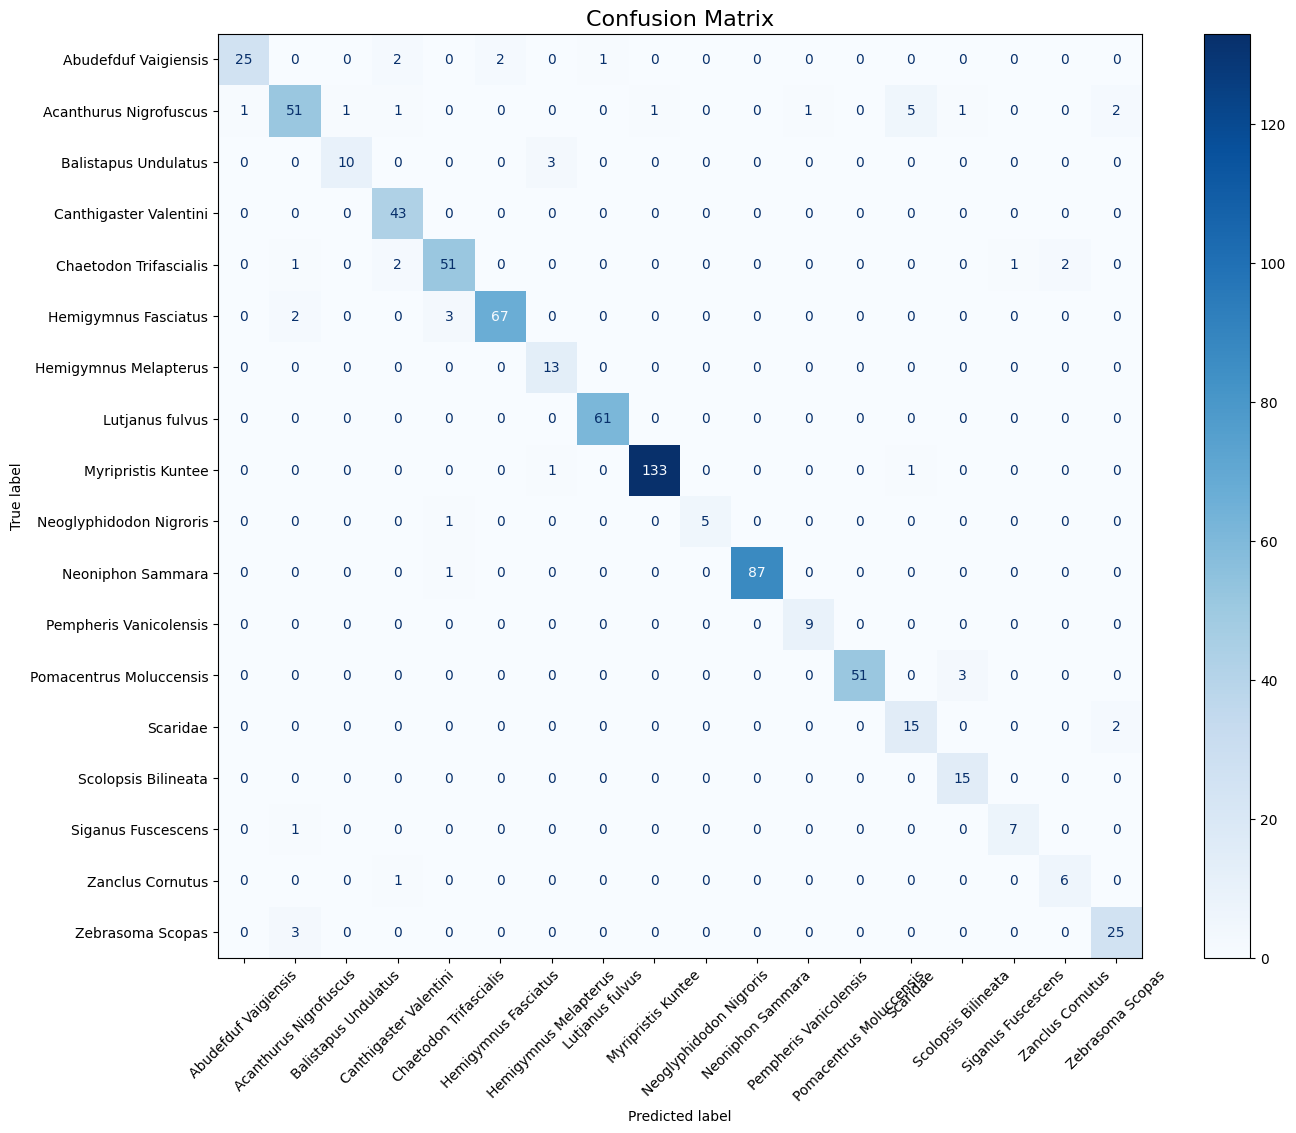

In [96]:
# NOT ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.87      0.91        30
 Acanthurus Nigrofuscus       0.85      0.89      0.87        64
   Balistapus Undulatus       1.00      0.77      0.87        13
 Canthigaster Valentini       0.88      0.98      0.92        43
 Chaetodon Trifascialis       0.93      0.91      0.92        57
   Hemigymnus Fasciatus       0.96      0.92      0.94        72
  Hemigymnus Melapterus       0.92      0.92      0.92        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       0.98      1.00      0.99        54
               Scaridae       0.79      0.88      0.83        17


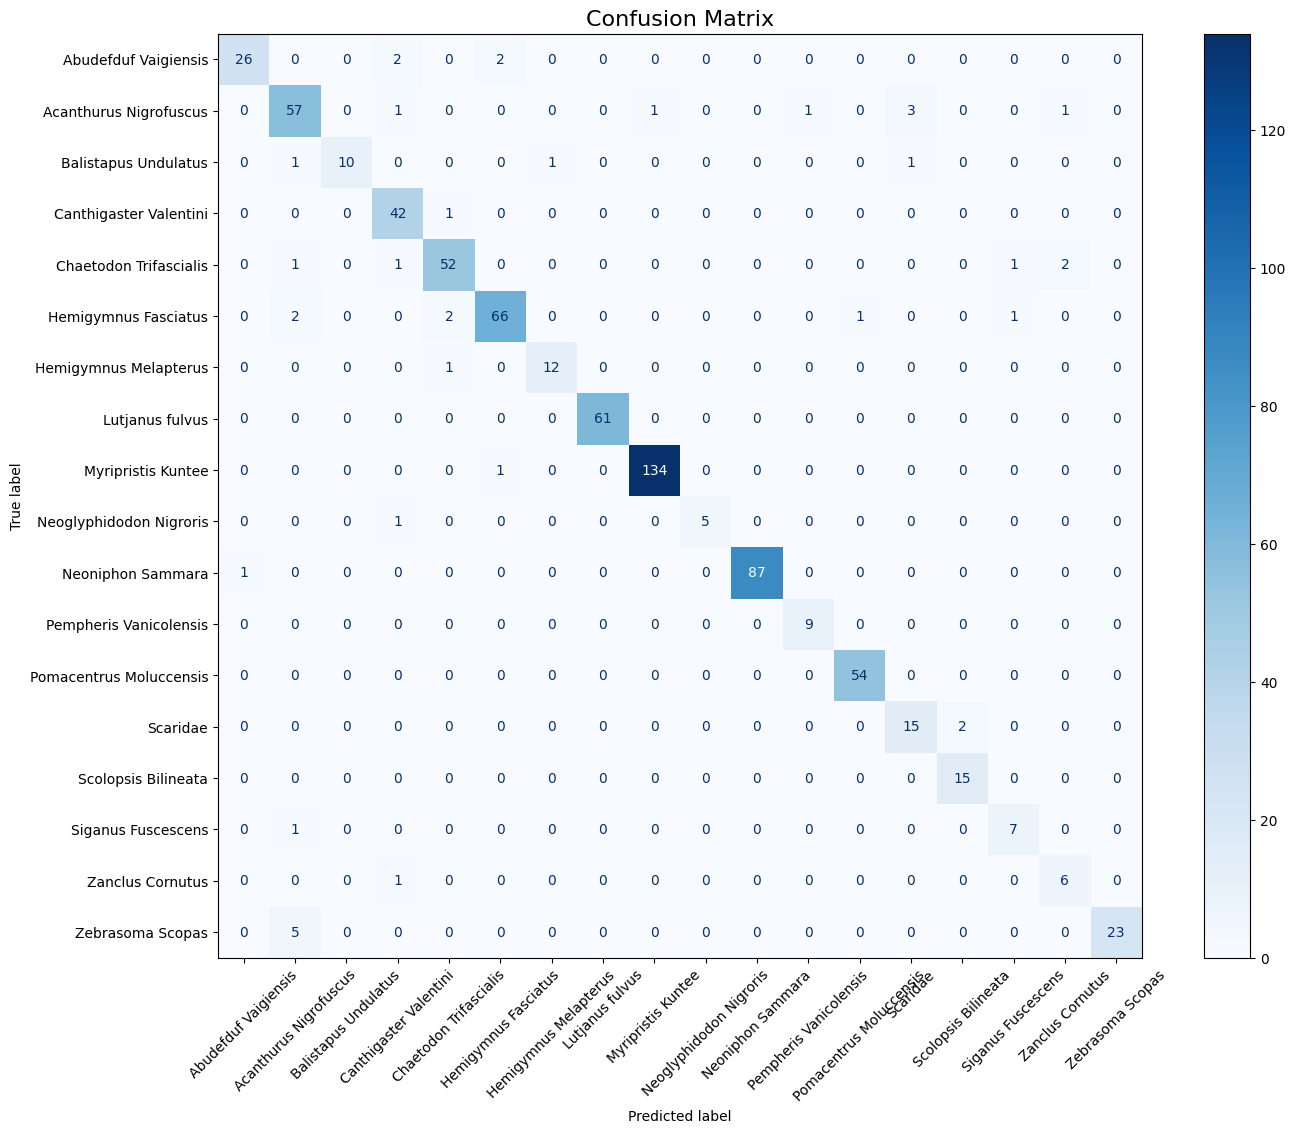

In [94]:
# ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.93      0.90      0.92        30
 Acanthurus Nigrofuscus       0.94      0.77      0.84        64
   Balistapus Undulatus       0.75      0.92      0.83        13
 Canthigaster Valentini       0.91      1.00      0.96        43
 Chaetodon Trifascialis       0.92      0.86      0.89        57
   Hemigymnus Fasciatus       0.99      0.92      0.95        72
  Hemigymnus Melapterus       0.67      0.92      0.77        13
        Lutjanus fulvus       0.98      0.95      0.97        61
     Myripristis Kuntee       0.99      0.98      0.98       135
Neoglyphidodon Nigroris       0.50      0.67      0.57         6
      Neoniphon Sammara       1.00      1.00      1.00        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       1.00      0.98      0.99        54
               Scaridae       0.80      0.94      0.86        17


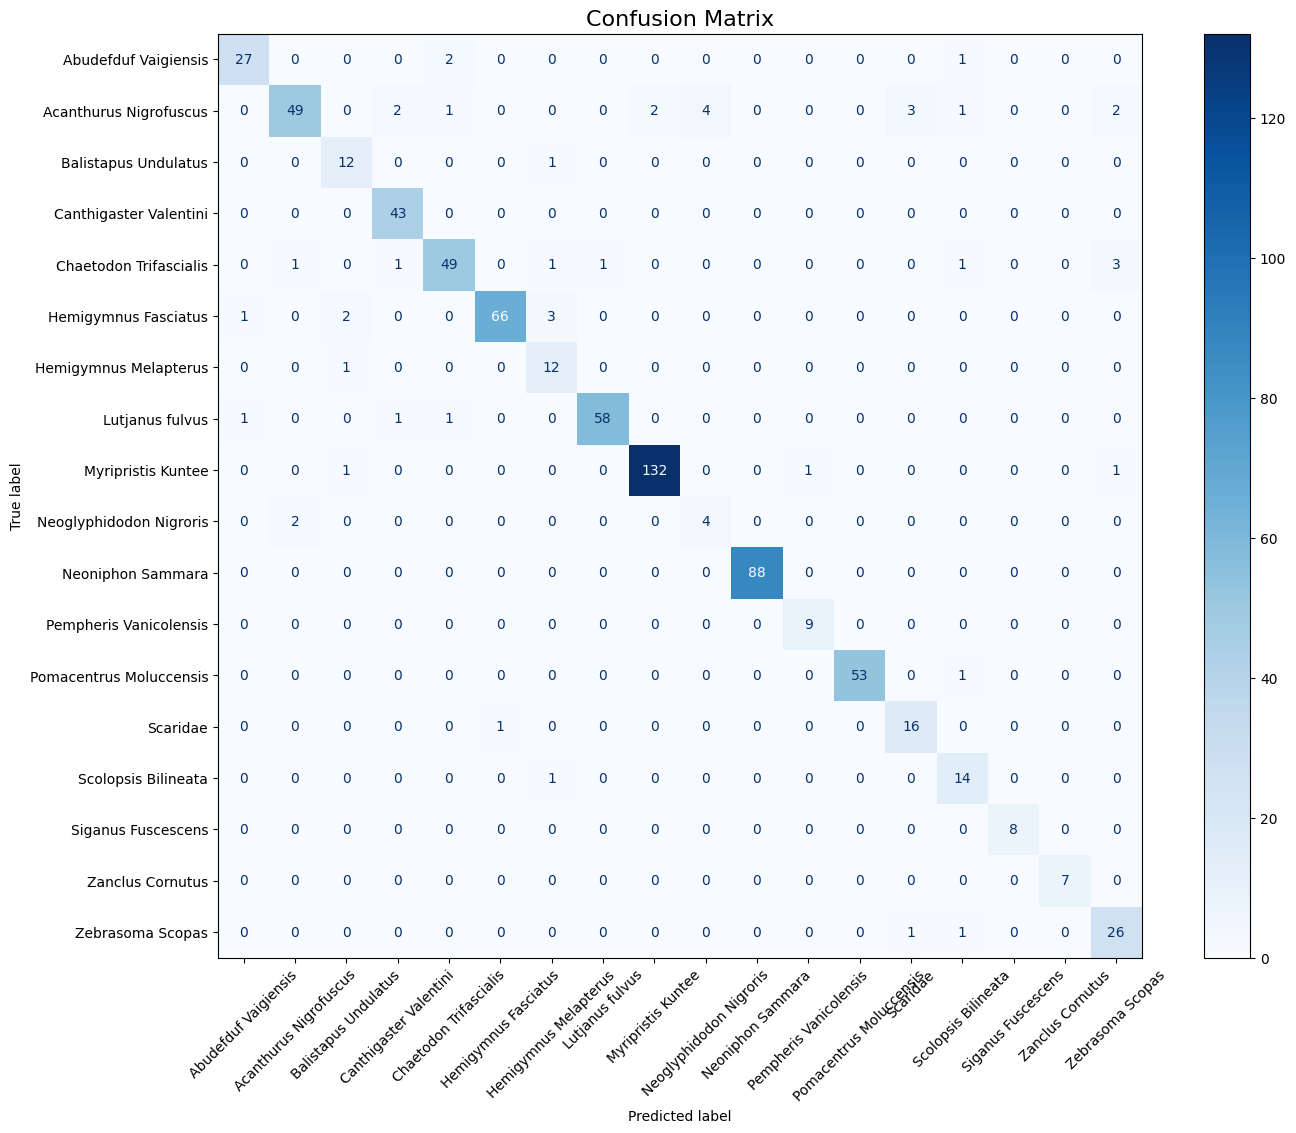

In [18]:
# ENHANCED + UNET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

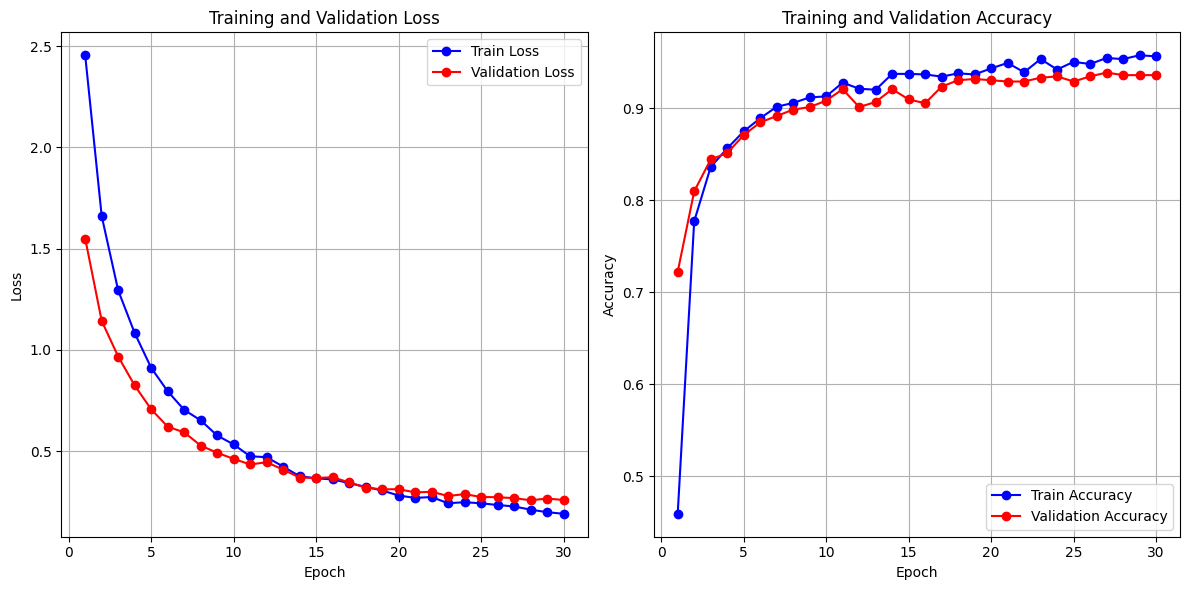

In [79]:
loaded_history = load_history_from_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv')
# NOT ENHANCED
plot_from_history(loaded_history, max_epochs=30) # use loaded history for csv

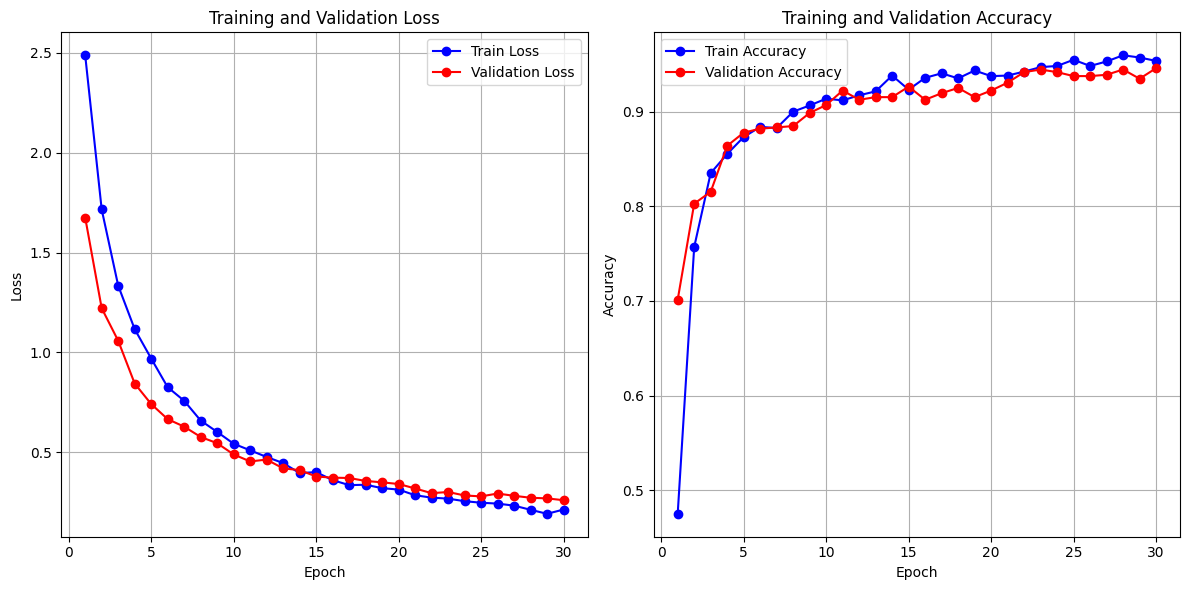

In [77]:
loaded_history = load_history_from_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED
plot_from_history(loaded_history, max_epochs=30) # use loaded history for csv

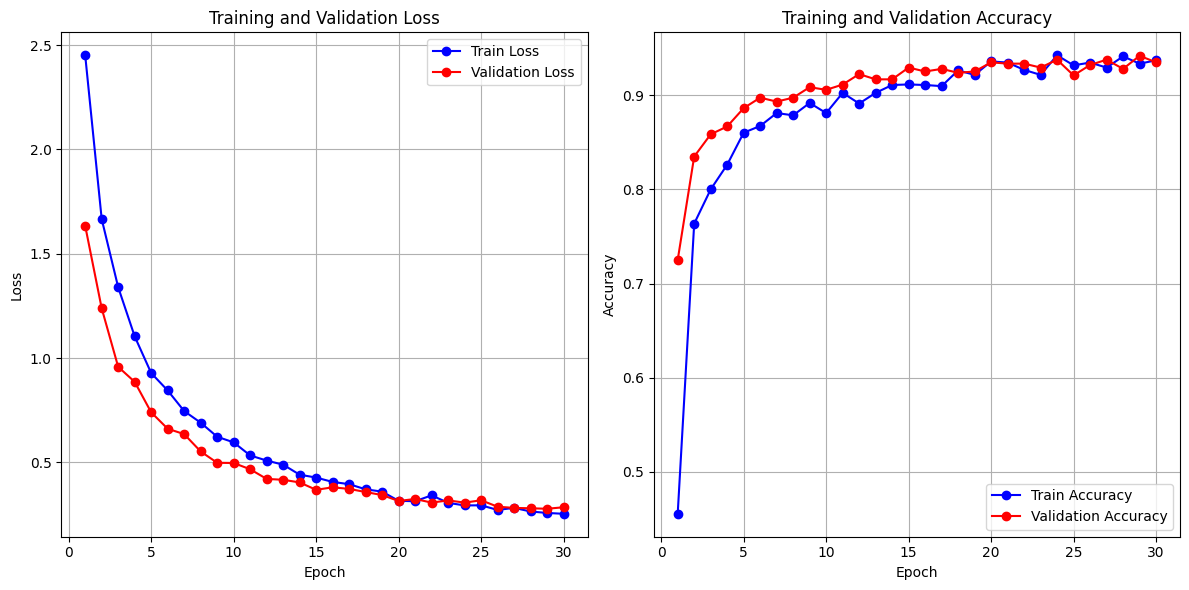

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED + UNET
plot_from_history(baseline_history, max_epochs=30) # use loaded history for csv

In [ ]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./data/DATASET/TEST/Lutjanus fulvus/fish_000000819594_03407.png"

random_path = './sample_images/SAMPLE_LUTJANUS.jpg'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, random_path, device, class_labels)


predicted_class_label = predicted_class
# confidence = prediction_probs.max().item()  # Get the highest probability
# predicted_class_index = prediction_probs.argmax().item()  # Index of the predicted class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


**===============Save Model=============**

In [ ]:
# NOT ENHANCED
import pandas as pd

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/model/TrainAndValidate_Rightway_TEST3_torch_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')

In [17]:
# ENHANCED
import pandas as pd

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/model/TrainAndValidate_Rightway_TEST3_torch_baselineb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_baselineb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.pth')

**===============LOAD Model=============**

In [95]:
torch_baseline_model.load_state_dict(torch.load('./saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth'))

<All keys matched successfully>

# PYTORCH (PROPOSED)

In [19]:
learning_rate = 0.001
epochs = 30

torch_proposed = resnet50(weights="IMAGENET1K_V1").to(device)

# FREEZE ALL LAYERS
for name, layer in torch_proposed.named_modules():
    for param in layer.parameters():
        param.requires_grad = False

class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.2):
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        concat = torch.cat((gap, gmp), dim=1)
        concat = self.dropout(concat)
        x = self.fc(concat)
        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_proposed_model.fc.parameters(), lr=learning_rate)


for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [21]:
# Train model
proposed_history = train_and_validate(torch_proposed_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.34it/s]


=> Train Loss=3.3630, Val Loss=1.5271 |  Train Acc=0.3746,  Val Acc=0.5556
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.68it/s]


=> Train Loss=1.4198, Val Loss=0.8708 |  Train Acc=0.6814,  Val Acc=0.7917
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.14it/s]


=> Train Loss=0.9960, Val Loss=0.6584 |  Train Acc=0.7820,  Val Acc=0.8389
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.46it/s]


=> Train Loss=0.7239, Val Loss=0.5497 |  Train Acc=0.8291,  Val Acc=0.8653
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.6234, Val Loss=0.4450 |  Train Acc=0.8487,  Val Acc=0.8875
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


=> Train Loss=0.5051, Val Loss=0.4674 |  Train Acc=0.8708,  Val Acc=0.8556
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.12it/s]


=> Train Loss=0.4477, Val Loss=0.4237 |  Train Acc=0.8999,  Val Acc=0.8764
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


=> Train Loss=0.3729, Val Loss=0.3589 |  Train Acc=0.9077,  Val Acc=0.9083
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


=> Train Loss=0.3452, Val Loss=0.3328 |  Train Acc=0.9065,  Val Acc=0.9125
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.40it/s]


=> Train Loss=0.2705, Val Loss=0.3373 |  Train Acc=0.9220,  Val Acc=0.8958
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.35it/s]


=> Train Loss=0.2733, Val Loss=0.3192 |  Train Acc=0.9315,  Val Acc=0.9153
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.2706, Val Loss=0.2858 |  Train Acc=0.9261,  Val Acc=0.9222
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.68it/s]


=> Train Loss=0.2588, Val Loss=0.2845 |  Train Acc=0.9285,  Val Acc=0.9236
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.09it/s]


=> Train Loss=0.2287, Val Loss=0.2723 |  Train Acc=0.9333,  Val Acc=0.9278
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.82it/s]


=> Train Loss=0.2054, Val Loss=0.2490 |  Train Acc=0.9375,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.62it/s]


=> Train Loss=0.1872, Val Loss=0.3178 |  Train Acc=0.9440,  Val Acc=0.9000
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.42it/s]


=> Train Loss=0.1747, Val Loss=0.2334 |  Train Acc=0.9500,  Val Acc=0.9319
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]


=> Train Loss=0.1711, Val Loss=0.2801 |  Train Acc=0.9464,  Val Acc=0.9181
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.43it/s]


=> Train Loss=0.1730, Val Loss=0.2379 |  Train Acc=0.9482,  Val Acc=0.9417
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.36it/s]


=> Train Loss=0.1867, Val Loss=0.2565 |  Train Acc=0.9500,  Val Acc=0.9292
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.44it/s]


=> Train Loss=0.1593, Val Loss=0.2495 |  Train Acc=0.9494,  Val Acc=0.9292
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.79it/s]


=> Train Loss=0.1751, Val Loss=0.2472 |  Train Acc=0.9392,  Val Acc=0.9167
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.81it/s]


=> Train Loss=0.1448, Val Loss=0.2359 |  Train Acc=0.9547,  Val Acc=0.9319
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.75it/s]


=> Train Loss=0.1356, Val Loss=0.2051 |  Train Acc=0.9625,  Val Acc=0.9431
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.90it/s]


=> Train Loss=0.1311, Val Loss=0.2256 |  Train Acc=0.9577,  Val Acc=0.9306
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.53it/s]


=> Train Loss=0.1290, Val Loss=0.2227 |  Train Acc=0.9535,  Val Acc=0.9389
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.52it/s]


=> Train Loss=0.1216, Val Loss=0.2208 |  Train Acc=0.9643,  Val Acc=0.9319
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.39it/s]


=> Train Loss=0.1331, Val Loss=0.1945 |  Train Acc=0.9589,  Val Acc=0.9500
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.20it/s]


=> Train Loss=0.1085, Val Loss=0.1968 |  Train Acc=0.9637,  Val Acc=0.9403
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.34it/s]

=> Train Loss=0.1152, Val Loss=0.2110 |  Train Acc=0.9655,  Val Acc=0.9403



Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.87      0.91        30
 Acanthurus Nigrofuscus       0.94      0.75      0.83        64
   Balistapus Undulatus       0.92      0.92      0.92        13
 Canthigaster Valentini       0.95      0.98      0.97        43
 Chaetodon Trifascialis       0.84      0.95      0.89        57
   Hemigymnus Fasciatus       0.94      0.92      0.93        72
  Hemigymnus Melapterus       0.87      1.00      0.93        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.96      0.99      0.97       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       1.00      1.00      1.00        54
               Scaridae       0.76      0.94      0.84        17


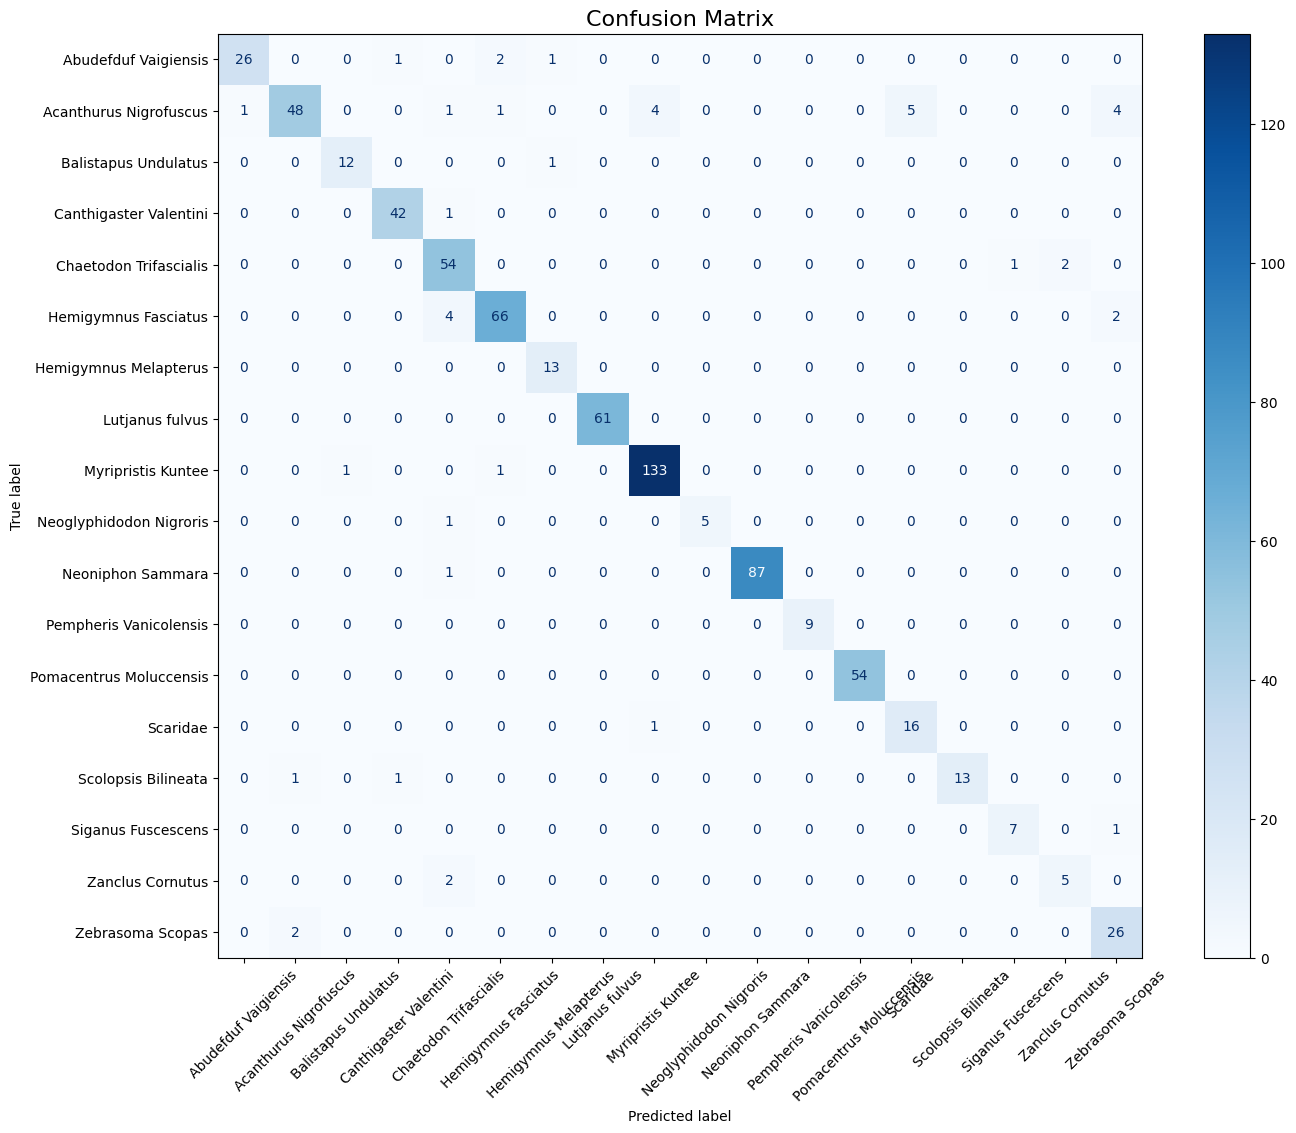

In [22]:
# NOT ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_proposed_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

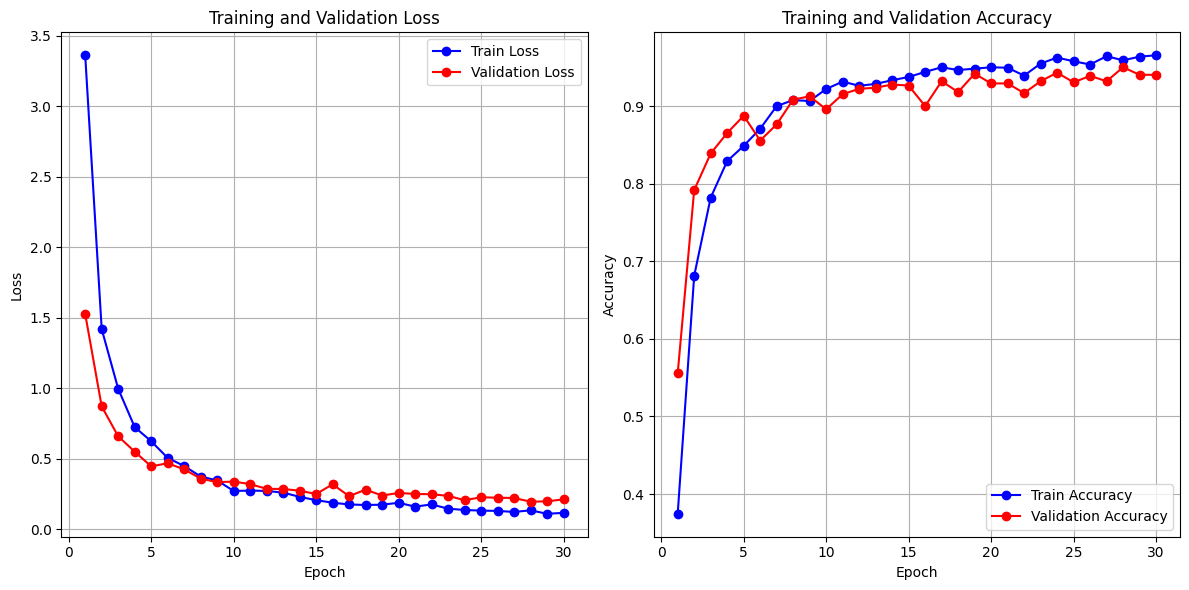

In [24]:
# loaded_history = load_history_from_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv')
# NOT ENHANCED
plot_from_history(proposed_history, max_epochs=30) 

**END======================================Save Model======================================END**

In [23]:
# NOT ENHANCED
import pandas as pd

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_proposedb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/model/TrainAndValidate_Rightway_TEST3_torch_proposedb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_proposedb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')